In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import sys
import time

In [2]:
print(os.listdir("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img"))

['test', 'train', 'val']


In [3]:
size = 300

In [4]:
#turn images into grey scale and put them into train list

train_images = []
train_labels = []
for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\train\\*"):
    label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        train_images.append(img)
        train_labels.append(label)

In [5]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
#turn images into grey scale and put them into test list

test_images = []
test_labels = []

for directory_path in glob.glob("C:\\Users\\a2-coutodeoliv\\OneDrive - UWE Bristol\\Images\\RF_CNN_img\\RF_CNN_img\\test\\*"):
    new_label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size,size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_images.append(img)
        test_labels.append(new_label)
        
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
#Encode labels from Text to int
from sklearn import preprocessing 

In [8]:
label_e = preprocessing.LabelEncoder()
label_e.fit(test_labels)
test_labels_encoded = label_e.transform(test_labels)
label_e.fit(train_labels)
train_labels_encoded = label_e.transform(train_labels)

In [9]:
#Split data into test and train datasets 
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [10]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0



In [11]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
model = Sequential()
model.add(Conv2D(8, (3,3),(2, 2), activation='relu', input_shape=(300,300,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(8, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())

x = model.output
x = Dense(2, activation ='linear', activity_regularizer=l1(0.001))(x)
prediction_layer = Dense(1,activation='sigmoid')(x)

In [13]:
#Import relevant packages

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score,accuracy_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import rfecv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer



In [14]:
#Get features from cnn to train the Rf

start = time.time()
X_for_RF = model.predict(x_train)
print(X_for_RF.shape)

#Get feature from cnn to test the Rf
X_test_feature = model.predict(x_test)

141/141 [==============================] - 6s 37ms/step
(4483, 128)
18/18 [==============================] - 1s 56ms/step


In [15]:
dtree = DecisionTreeClassifier(max_depth=3)

In [16]:
dtree = dtree.fit(X_for_RF, y_train)
stop = time.time()
print(f"Training time: {stop - start}s")

Training time: 8.788287162780762s


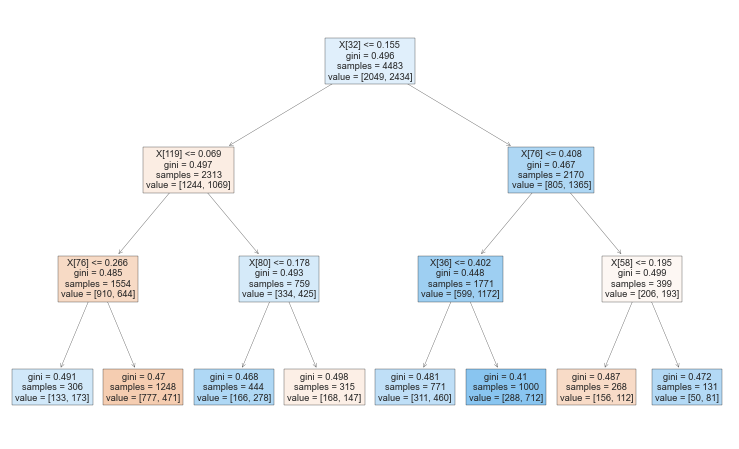

In [17]:

plt.figure(figsize=(13,8))
tree.plot_tree(dtree, filled=True)
plt.show()
#Two  lines to make our compiler able to draw:



Accuracy =  0.5782918149466192


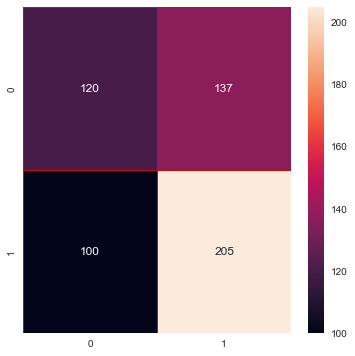

In [18]:
#Now predict using the trained RF model. 
prediction_RF = dtree.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF_1 = label_e.inverse_transform(prediction_RF)

print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF_1))
cm = confusion_matrix(test_labels, prediction_RF_1)


f, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, linewidth=.5, linecolor="r", fmt=".0f", ax = ax)
plt.show()

In [19]:
precision = precision_score(y_test,prediction_RF)
recall = recall_score(y_test, prediction_RF)
f05 =(1.25 * precision * recall)/ (0.25 * precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F05:", f05)

Precision: 0.5994152046783626
Recall: 0.6721311475409836
F05: 0.6126718469814704
